# Command Line

It is possible to run a model from the command line. The model function needs to be importable from Python. Therefore we create a `model.py` files.

In [1]:
%%writefile model.py
import numpy as np

def model(theta, x):
    mu1, sig1, mu2, sig2 = theta
    return gaussian(x, mu1, sig1) + gaussian(x, mu2, sig2)

def gaussian(x, mu, sig):
    return np.exp(-0.5*(x-mu)**2/sig**2.)/(sig*np.sqrt(2.*np.pi))

Writing model.py


From this model function we create noisy data and save it to file.

In [2]:
from emceex import EnsembleSampler
from model import model
import numpy as np

In [3]:
theta_true = [-1., 1., 1., 0.3]

In [4]:
N = 100
noise = 0.1

x = np.linspace(-5., 5., N)
yerr = noise * np.ones(N)
rng = np.random.default_rng()
y = model(theta_true, x) + rng.normal(loc=0., scale=yerr, size=N)

np.savetxt("data.dat", np.stack((x, y, yerr)).T)

The configuration of the sampler happens in `.yaml` files.

In [5]:
%%writefile model.yaml
---
parameters:
    mu1:
        min: -5.
        max: 0.
        log: False
    sig1:
        min: 0.01
        max: 10.
        log: True
    mu2:
        min: 0.
        max: 5.
        log: False
    sig2:
        min: 0.01
        max: 10.
        log: True
        
datafile: data.dat
dumpfile: sampler.dump

model:
    file: model.py
    func: model
    
convergence:
    beta: 100.
    delta: 1.e-2
    
N_steps: 10_000
thin_by: 1
interval: 100
N_threads: 0
N_walkers: 16

moves:
    StretchMove: 0.1
    DEMove: 0.3
    DESnookerMove: 0.6
...

Writing model.yaml


This can now be run from the command line. The `-vv` flag increases the verbosity to display information and a progress bar. The `--restart` option forces a restart of the simulation, even if a matching dump file exists.

In [6]:
!emceex model.yaml -vv --restart

Reading 'model.yaml'.
Reading 'data.dat'.
Loading model function 'model' from 'model.py'.

Starting...
# dimensions:         4
# walkers:           16
# threads:            0

beta: 0.988 | delta: 0.703:  30%|██▋      | 2981/10000 [00:17<00:40, 174.11it/s]


We can load the dump file and plot the model.

In [7]:
mcmc = EnsembleSampler.load_dump("sampler.dump")

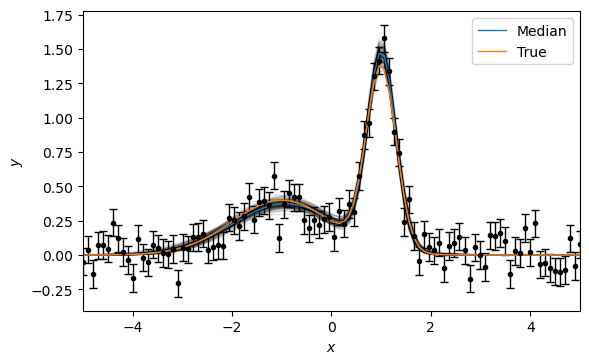

In [8]:
fig, ax = mcmc.plot_data(nsamples=100, theta=[mcmc.get_theta(which="median"), theta_true], theta_labels=["Median", "True"])
ax.set_xlim(x.min(), x.max())
fig.tight_layout()